# CNN(卷積神經網路) 金屬表面分類

- 金屬類型影像資料集    
- https://ieee-dataport.org/open-access/data-set-various-metal-types
- test data set
- https://www.kaggle.com/datasets/fantacher/neu-metal-surface-defects-data

### 1. 引入模組
- 如果沒有此套件需要先執行指令安裝

`!pip install imutils`

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from imutils import paths
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, Dropout, Flatten ,Conv2D, MaxPool2D 
from sklearn.metrics import confusion_matrix, roc_auc_score

import cv2
import os


### 2. 匯入資料集  
- imagePaths: 匯入資料集
- IMAGE_DIMS = (20, 20, 3), 影像尺寸為20x20, 因為是RGB三色，所以x3

In [2]:
imagePaths = sorted(list(paths.list_images(".\\Dataset\\CNN\\Variour_metal_types\\")))

IMAGE_DIMS = (20, 20, 3)
data = []
labels = []

In [3]:
len(imagePaths)

200

In [4]:
imagePaths[0]

'.\\Dataset\\CNN\\Variour_metal_types\\copper\\img_1.jpg'

### 3. 整理資料集
- data: 資料集，存放由cv2.imread()讀檔，並把尺寸轉為我們定義的大小的圖檔資料
- labels: 標籤，將圖片的類別放在labels中
- 如果未來需要新增資料集類別，可以新增or修改類別資料夾，擴充你要的資料類型


In [5]:
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

    # extract set of class labels from the image path and update the
    # labels list
    # l = label = imagePath.split(os.path.sep)[-2]
    if imagePath.split(os.path.sep)[-2] == 'iron':
        l = 0
    elif imagePath.split(os.path.sep)[-2] == 'copper':
        l = 1
    labels.append(l)

In [11]:
print(len(data[0]))
print(len(data[0][0]))

20
20


In [12]:
print(data[0][0])

[[137. 142. 167.]
 [136. 143. 168.]
 [142. 150. 173.]
 [148. 162. 181.]
 [154. 170. 187.]
 [154. 175. 190.]
 [162. 184. 196.]
 [168. 192. 204.]
 [170. 195. 205.]
 [172. 197. 207.]
 [172. 194. 205.]
 [168. 190. 201.]
 [170. 187. 200.]
 [169. 186. 199.]
 [167. 180. 196.]
 [159. 172. 188.]
 [158. 168. 186.]
 [156. 166. 184.]
 [153. 163. 181.]
 [153. 163. 181.]]


### 4. 整理資料集格式  
- Data: 存放轉為nparray的資料
- Label: 存放轉為nparray的資料


In [13]:
Data = np.array(data, dtype="float")
Label = np.array(labels)

print("Data shape:" + str(Data.shape))
print("Label shape:" + str(Label.shape))

Data shape:(200, 20, 20, 3)
Label shape:(200,)


In [14]:
Data[0][0]

array([[137., 142., 167.],
       [136., 143., 168.],
       [142., 150., 173.],
       [148., 162., 181.],
       [154., 170., 187.],
       [154., 175., 190.],
       [162., 184., 196.],
       [168., 192., 204.],
       [170., 195., 205.],
       [172., 197., 207.],
       [172., 194., 205.],
       [168., 190., 201.],
       [170., 187., 200.],
       [169., 186., 199.],
       [167., 180., 196.],
       [159., 172., 188.],
       [158., 168., 186.],
       [156., 166., 184.],
       [153., 163., 181.],
       [153., 163., 181.]])

### 5.將資料分為train、test資料集


In [15]:
x_train, x_test, y_train, y_test = train_test_split(Data, Label, test_size=0.2, random_state=0, stratify=Label)

# 訓練資料筆數與維度大小
print("Training data shape:" + str(x_train.shape))
print("Training label shape:" + str(y_train.shape))
# 測試資料筆數與維度大小
print("Test data shape:" + str(x_test.shape))
print("Test label shape:" + str(y_test.shape))

Training data shape:(160, 20, 20, 3)
Training label shape:(160,)
Test data shape:(40, 20, 20, 3)
Test label shape:(40,)


### 6. Label前處理，轉為onehot的格式
- labels內容進行one-hot encoding，才符合Keras所要求的資料結構。  


In [16]:
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

In [19]:
y_train_onehot[0]

array([1., 0.], dtype=float32)

### 7. 建立CNN Model

- model.add(Conv2D( )) 建立卷積層  
    - filter = 16，代表輸出空間的維度大小(即為卷積中濾波器輸出數量)。  
    - Kernel_size = (5, 5)，常為為(3,3)或是(5,5)
    - padding = 'same'，代表卷積層取週邊kernel_size的滑動視窗時，若超越邊界時，一律補零處理
    - input_shape=(28,28,1)代表圖片尺寸為28*28且為黑白。(28,28,3)代表尺寸為28*28且為三色
  
- model.add(MaxPool2D( )) 建立池化層  
    - pool_size = (2,2)，池化層視窗的大小
    
- model.add(Dropout())  
    - 使用Dropout防止過度擬合，每次訓練時拿走固定比例的神經元。  

- model.add(Flatten( )) 建立平坦層  
    
- model.add(Dense(128)) 建立隱藏層(密集層)
    - 128個神經元


In [20]:
model = Sequential()  
# 建立卷積層   
model.add(Conv2D(filters=16,  
                 kernel_size=(5,5),  
                 padding='same',  
                 input_shape=IMAGE_DIMS,
                 activation='relu')) 
# 建立池化層 
model.add(MaxPool2D(pool_size=(2,2)))  
  
# 建立卷積層 
model.add(Conv2D(filters=32,  
                 kernel_size=(5,5),  
                 padding='same',  
                 activation='relu'))   

# 建立池化層 
model.add(MaxPool2D(pool_size=(2,2)))


# 建立Dropout
model.add(Dropout(0.25))
# 建立平坦層
model.add(Flatten())
# 建立隱藏層
model.add(Dense(128, activation='relu'))  
# 建立Dropout_2
model.add(Dropout(0.5))


# 建立輸出層
model.add(Dense(2, activation='softmax'))
model.summary()  
print("") 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 16)        1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 flatten (Flatten)           (None, 800)               0

### 8. 定義訓練方式與訓練模型    

- optimizer: 設定訓練時的優化方法，深度學習中使用'adam'可讓訓練更快收斂，並提高準確率。  
- metrics: 設定評估模型的方法是'accuracy' (準確率)。  

#### fit
- validation_split = 0.2: 用於沒有提供驗證集時，將訓練資料集取出20%當作驗證資料集。  


In [21]:
#在訓練模型之前, 我們必須先使用 compile 方法
# loss : 設定 loss function, 深度學習通常使用'cross_entropy'交叉熵訓練效果較好.
# optimizer : 設定訓練時的優化方法，深度學習中使用'adam'可讓訓練更快收斂，並提高準確率
# metrics : 設定評估模型的方式是 accuracy (準確率)
# 定義訓練方式 
# from tensorflow.keras.optimizers import Adam, SGD
# adam = Adam(lr=0.0005)

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
train_history = model.fit(x = x_train, 
                          y = y_train_onehot,
                          validation_split=0.2,
                          epochs=5, 
                          batch_size=50, 
                          verbose=1)

Epoch 1/5
3/3 [==============================] - 2s 230ms/step - loss: 9.6161 - accuracy: 0.5547 - val_loss: 0.8002 - val_accuracy: 0.8438
Epoch 2/5
3/3 [==============================] - 0s 57ms/step - loss: 2.7834 - accuracy: 0.7891 - val_loss: 0.3317 - val_accuracy: 0.9375
Epoch 3/5
3/3 [==============================] - 0s 63ms/step - loss: 1.1462 - accuracy: 0.8984 - val_loss: 1.4938 - val_accuracy: 0.7188
Epoch 4/5
3/3 [==============================] - 0s 58ms/step - loss: 0.8819 - accuracy: 0.8828 - val_loss: 0.3630 - val_accuracy: 0.9375
Epoch 5/5
3/3 [==============================] - 0s 63ms/step - loss: 0.9676 - accuracy: 0.8906 - val_loss: 0.0727 - val_accuracy: 0.9688


### 儲存訓練好的模型 


In [22]:
model.save('CNN_model.h5')

### 建立 show_train_history function 顯示訓練過程   


In [23]:
# 訓練步驟會將每一個訓練週期的 accuracy 與 loss 記錄在 train_history 變數. 
# 我們可以使用下面程式碼讀取 train_history 以圖表顯示訓練過程:
import matplotlib.pyplot as plt  
def show_train_history(train_history, train, validation):  
    plt.plot(train_history.history[train])  
    plt.plot(train_history.history[validation])  
    plt.title('Train History')  
    plt.ylabel(train)  
    plt.xlabel('Epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show() 

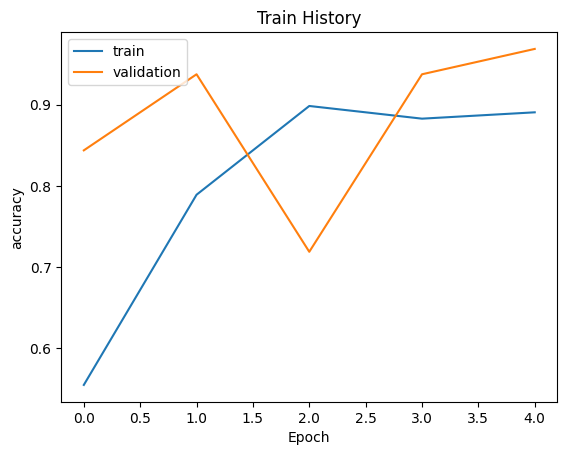

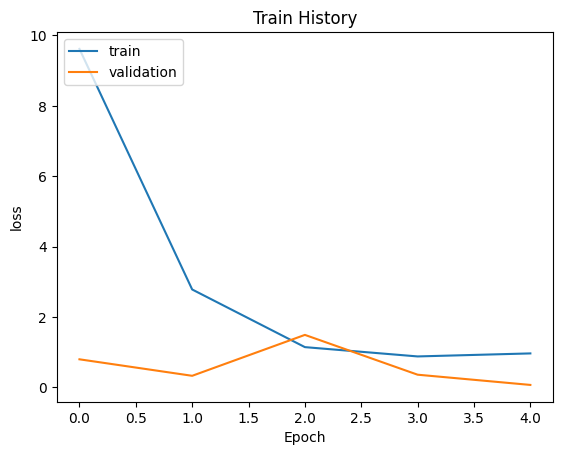

In [24]:
# 1. 圖表顯示 accuracy
show_train_history(train_history, 'accuracy', 'val_accuracy')
# 2. 圖表顯示 loss
show_train_history(train_history, 'loss', 'val_loss')

### 使用測試資料評估模型準確率


In [25]:
scores = model.evaluate(x_test, y_test_onehot)  
print(" Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))

2/2 [==============================] - 0s 21ms/step - loss: 0.0631 - accuracy: 0.9500

	[Info] Accuracy of testing data = 95.0%


In [26]:
scores

[0.06308794766664505, 0.949999988079071]

### 查看10筆預測結果資料  


	[Info] Making prediction to x_Test_norm



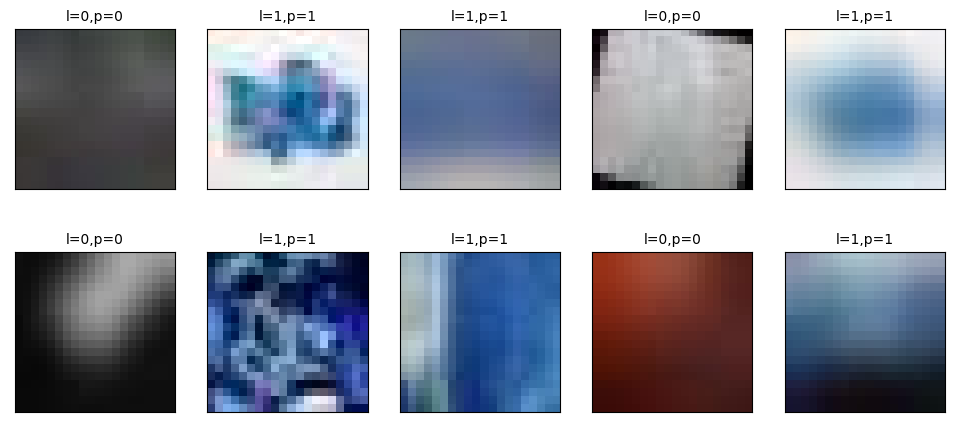

In [30]:
import matplotlib.pyplot as plt  

def plot_images_labels_predict(images, labels, prediction, idx, num=10):  
    fig = plt.gcf()  
    fig.set_size_inches(12, 14)  
    if num > 25: num = 25  
    for i in range(0, num):  
        ax=plt.subplot(5,5, 1+i)  
        ax.imshow(images[idx] / 255, cmap='binary')  
        title = "l=" + str(labels[idx])  
        if len(prediction) > 0:  
            title = "l={},p={}".format(str(labels[idx]), str(prediction[idx]))  
        else:  
            title = "l={}".format(str(labels[idx]))  
        ax.set_title(title, fontsize=10)  
        ax.set_xticks([]); ax.set_yticks([])  
        idx+=1  
    plt.show()  
    
print(" Making prediction to x_Test_norm")  
#prediction = model.predict_classes(x_test)  # Making prediction and save result to prediction  
predict_x=model.predict(x_test) 
prediction=np.argmax(predict_x,axis=1)


print("")   
plot_images_labels_predict(x_test, y_test, prediction, idx=20)